In [1]:
import pandas as pd
import numpy as np
import re
import os
from copy import copy
from os.path import join
from gtfparse import read_gtf
import csv
import pickle as pkl
from pprint import pprint
from BCBio.GFF import GFFExaminer
from utils.gtf_io import my_gtf_read,my_gtf_write,CategorizedGTF
from utils.isoform_classes import genePredReader, genePredRecord, reference_genePred_TSS_TTS_parser
from utils.transcriptomic_features.shared_classes import \
    SharedTTS, SharedTSS, SharedExon, SharedJunction, SharedSpliceSite, SharedTranscriptStructure
from utils.transcriptomic_features.ref_classes import RefTranscriptIsoform
from utils.transcriptomic_features.parse_transcriptomic_features import reference_genePred_parser
from utils.isoform_analysis import ReferenceSharedFeatureCollection,GffCompareMergedTranscripts,SupportInfo
from collections import defaultdict
from copy import copy
from bx.intervals import Interval, IntervalTree
from matplotlib_venn import venn3_unweighted,venn3
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from utils.file_utils import read_bed,write_bed
import pyfaidx
from utils.transcriptomic_features.ref_classes import TranscriptIsoformWithSeq
from Bio.Seq import Seq
from Bio import SeqIO
import seaborn as sns
from scipy.stats import mannwhitneyu
import scipy.sparse as sp
import anndata as ad
from sklearn.preprocessing import normalize

sns.set_style("white")
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 'truetype'

%load_ext autoreload
%autoreload 2
%load_ext jupyter_spaces

# Processing of Query Transcripts

In [2]:
def get_sqanti_sample_fp(sample_name):
    SQUANTI3_output_dn="SQANTI3_ref_gtf_merged_2"
    pacbio_analysis_root="PacBio/downstream"
    sqanti_dir=os.path.join(pacbio_analysis_root,"{}/{}".format(sample_name,SQUANTI3_output_dn))
    sqanti_sample_fp_dict = {
        "filtered_lite_classification":os.path.join(
            sqanti_dir,"{}.aligned.5merge.collapsed_classification.filtered_lite_classification.txt".format(sample_name)
        ),
        "filtered_lite_gtf":os.path.join(
            sqanti_dir,"{}.aligned.5merge.collapsed_classification.filtered_lite.gtf".format(sample_name)
        ),
        "filtered_lite_junctions":os.path.join(
            sqanti_dir,"{}.aligned.5merge.collapsed_classification.filtered_lite_junctions.txt".format(sample_name)
        ),
        "collate_df":os.path.join(
            sqanti_dir,"{}.aligned.annotated.csv".format(sample_name)
        ),
        "genePred":os.path.join(
            sqanti_dir,"{}.aligned.5merge.collapsed_corrected.genePred".format(sample_name)
        )
    }
    for fp in sqanti_sample_fp_dict.values():
        assert os.path.exists(fp)
    return sqanti_sample_fp_dict

def get_suppa2_event_fp(event_name):
    pacbio_analysis_root="PacBio/downstream"
    suppa2_events_dir=os.path.join(pacbio_analysis_root,"combined/combined_filter_gtfs/SUPPA2_events")
    suppa2_event_fp=join(
        suppa2_events_dir,
        "gffcmp.query.all_samples.local_events_{}_strict.ioe".format(event_name)
    )
    return suppa2_event_fp
    

In [3]:
from utils.isoform_analysis import GroupedIsoformV2
# Small sample analysis
if True:
    UMI_threshold={
        'PS017-T2':100,
        'PS017-T1.1':100,
        'PS018-N':100,
        'PS018-T':100,
        'PS021-N':15,
        'PS025-T':4,
        'PS026-N2':100,
        'PS026-T':4,
        'PS028-T':100
    }
    
    reference_fp={
        "reference_genePred_fp":"PacBio/downstream/combined/refAnnotation.fromgtf.genePred",
        "TSS_bed_fp":"references/TSS/TSS.merged.formatted.win48.bed",
        "TTS_bed_fp":"references/polyA/TTS.merged.formatted.win48.bed"
    }
    sample_name_map={
        1:"PS017-T1.1",
        2:"PS017-T2",
        3:"PS018-N",
        4:"PS018-T",
        5:"PS021-N",
        6:"PS025-T",
        7:"PS026-N2",
        8:"PS026-T",
        9:"PS028-T"
    }

    
suppa2_event_fp={
    "suppa2_local_event_fp":{
        "A3":"PacBio/downstream/combined/combined_filter_gtfs/SUPPA2_events_BS/gffcmp.query.all_samples.local_events_A3_strict.ioe",
        "A5":"PacBio/downstream/combined/combined_filter_gtfs/SUPPA2_events_BS/gffcmp.query.all_samples.local_events_A5_strict.ioe",
        "MX":"PacBio/downstream/combined/combined_filter_gtfs/SUPPA2_events_BS/gffcmp.query.all_samples.local_events_MX_strict.ioe",
        "RI":"PacBio/downstream/combined/combined_filter_gtfs/SUPPA2_events_BS/gffcmp.query.all_samples.local_events_RI_strict.ioe",
        "SE":"PacBio/downstream/combined/combined_filter_gtfs/SUPPA2_events_BS/gffcmp.query.all_samples.local_events_SE_strict.ioe",
        "AF":"PacBio/downstream/combined/combined_filter_gtfs/SUPPA2_events_BV/gffcmp.query.all_samples.local_events_AF_variable_48.ioe",
        "AL":"PacBio/downstream/combined/combined_filter_gtfs/SUPPA2_events_BV/gffcmp.query.all_samples.local_events_AL_variable_48.ioe",
    },
    "gffcmp_tracking_fp":"PacBio/downstream/combined/combined_filter_gtfs/gffcmp.query.all_samples.tracking"
}

sample_analysis_fp={
    k:get_sqanti_sample_fp(k) for k in sample_name_map.values()
}

gffcmp_fp={
    "genePred_fp":"PacBio/downstream/combined/combined_filter_gtfs/gffcmp.query.all_samples.combined.genePred",
    "gffcmp_gtf_fp":"PacBio/downstream/combined/combined_filter_gtfs/gffcmp.query.all_samples.combined.gtf",
    "gffcmp_tracking_fp":"PacBio/downstream/combined/combined_filter_gtfs/gffcmp.query.all_samples.tracking",
    "filtered_lite_classification":"PacBio/downstream/combined/combined_filter_gtfs/SQANTI3_ref_gtf_merged_2/gffcmp.query.all_samples.combined_classification.txt"
}

chained_fp={
    "chained_tracking_fp":"PacBio/chain/SQANTI3_ref_gtf_merged_2/all_samples.chained_ids.filtered2_lite.txt",
    "genePred_fp":"PacBio/chain/SQANTI3_ref_gtf_merged_2/all_samples.chained_classification.filtered2_lite.genePred",
    "filtered_lite_classification":"PacBio/chain/SQANTI3_ref_gtf_merged_2/all_samples.chained_classification.filtered2_lite_classification.txt"
}

giv2=GroupedIsoformV2(
    sample_name_map=sample_name_map,
    sample_analysis_fp=sample_analysis_fp,
    reference_fp=reference_fp,
    UMI_threshold=UMI_threshold,
    load_ref_collection=True,
    suppa2_event_fp=suppa2_event_fp,
    gffcmp_fp=gffcmp_fp,
    chained_fp=chained_fp,
    test_mode=False
)

===============Loading reference genePred===============


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358366/358366 [02:57<00:00, 2017.64it/s]


# dropped transcript isoforms:  24463
===============Loading reference TSS&TTS===============
Parsing TSS...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281974/281974 [00:18<00:00, 15044.82it/s]


Parsing TTS...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 756752/756752 [01:00<00:00, 12580.59it/s]


===============Loading class_df for each sample===============
Loading class_df for PS017-T1.1...finished
Loading class_df for PS017-T2...finished
Loading class_df for PS018-N...finished
Loading class_df for PS018-T...finished
Loading class_df for PS021-N...finished
Loading class_df for PS025-T...finished
Loading class_df for PS026-N2...finished
Loading class_df for PS026-T...finished
Loading class_df for PS028-T...finished
Loading collate_info for PS017-T1.1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279678/279678 [00:12<00:00, 22351.74it/s]


Loading collate_info for PS017-T2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303583/303583 [00:13<00:00, 22139.18it/s]


Loading collate_info for PS018-N


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209643/209643 [00:09<00:00, 22234.83it/s]


Loading collate_info for PS018-T


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185907/185907 [00:08<00:00, 22379.26it/s]


Loading collate_info for PS021-N


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57153/57153 [00:02<00:00, 23313.12it/s]


Loading collate_info for PS025-T


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8144/8144 [00:00<00:00, 23440.45it/s]


Loading collate_info for PS026-N2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179500/179500 [00:07<00:00, 23439.06it/s]


Loading collate_info for PS026-T


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6422/6422 [00:00<00:00, 22737.92it/s]


Loading collate_info for PS028-T


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207433/207433 [00:08<00:00, 23265.00it/s]


===============filter cells by collate df UMI===============
sample: PS017-T1.1 original #CB: 52215 after filter #CB: 265
sample: PS017-T2 original #CB: 37779 after filter #CB: 231
sample: PS018-N original #CB: 34141 after filter #CB: 244
sample: PS018-T original #CB: 44869 after filter #CB: 452
sample: PS021-N original #CB: 31440 after filter #CB: 246
sample: PS025-T original #CB: 6062 after filter #CB: 240
sample: PS026-N2 original #CB: 43360 after filter #CB: 314
sample: PS026-T original #CB: 5376 after filter #CB: 74
sample: PS028-T original #CB: 32216 after filter #CB: 131
===============filter cells by Illumina barcodes===============
sample_name: PS018-N, before filter #CB: 244, after filter #CB: 241
sample_name: PS017-T1.1, before filter #CB: 265, after filter #CB: 229
sample_name: PS025-T, before filter #CB: 240, after filter #CB: 172
sample_name: PS018-T, before filter #CB: 452, after filter #CB: 452
sample_name: PS021-N, before filter #CB: 246, after filter #CB: 245
sample_n

In [4]:
giv2.parse_query_transcript_isoform(parse_exon=False,parse_junction=False,parse_tss_tts=False)

Parsing Isoforms in PS017-T1.1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108731/108731 [00:07<00:00, 14624.53it/s]


Parsing Isoforms in PS017-T2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249721/249721 [00:37<00:00, 6739.42it/s]


Parsing Isoforms in PS018-N


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155720/155720 [00:10<00:00, 15472.96it/s]


Parsing Isoforms in PS018-T


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98411/98411 [00:06<00:00, 14133.07it/s]


Parsing Isoforms in PS021-N


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65004/65004 [00:03<00:00, 16363.89it/s]


Parsing Isoforms in PS025-T


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3868/3868 [00:00<00:00, 14398.09it/s]


Parsing Isoforms in PS026-N2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156486/156486 [00:09<00:00, 16361.57it/s]


Parsing Isoforms in PS026-T


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 12858.16it/s]


Parsing Isoforms in PS028-T


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98372/98372 [00:08<00:00, 11233.82it/s]


In [5]:
giv2.parse_gffcmp_merged_transcript_isoform()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [00:49<00:00, 2519.43it/s]


In [1]:
giv2.parse_suppa2_events()

In [7]:
giv2.differential_analysis(
    chained_transcripts=False,
    ref_collections=False,
    gffcmp_transcripts=True,
    suppa2_events=False
)

Processing gffcmp transcripts


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [00:01<00:00, 120159.77it/s]


In [ ]:
giv2.print_shared_features(print_example=False)

## Statistical test by event-level sparse matrix

In [13]:
from scipy.stats import fisher_exact,mannwhitneyu
from collections import Counter
def MWU_rank_sum_test(self,count_ad,feature_id=None,group1="Epi_tumor",group2="Epi_normal",illumina_intersect=False,log1p=True):
    if type(group1)==str:
        group1=self.illumina_sample_info.cell_type_sets_pacbio_intersect["Epi_tumor"]
    if type(group2)==str:
        group2=self.illumina_sample_info.cell_type_sets_pacbio_intersect["Epi_normal"]
    else:
        if illumina_intersect:
            group1=self.cell_barcodes_illumina_intersect.intersection(group1)
            group2=self.cell_barcodes_illumina_intersect.intersection(group2)
    
    group1=list(group1)
    group2=list(group2)
    if feature_id is None:
        x=count_ad[group1,:].X.toarray()
        y=count_ad[group2,:].X.toarray()
    else:
        x=count_ad[group1,feature_id].X.toarray()[:,0]
        y=count_ad[group2,feature_id].X.toarray()[:,0]
    print("Performing MWU Test...")
    p_vals_MWU=mannwhitneyu(x,y,axis=0).pvalue
    
    print("Computing Percentage...")
    pct1=(x>0).sum(axis=0)/len(group1)
    pct2=(y>0).sum(axis=0)/len(group2)
    
    print("Computing LogFC...")
    if log1p:
        logfc=np.log1p(np.mean(np.expm1(x),axis=0))-np.log1p(np.mean(np.expm1(y),axis=0))
    else:
        logfc=np.log1p(np.mean(x),axis=0)-np.log1p(np.mean(y,axis=0))
        
    return {
        "pct1":pct1,
        "pct2":pct2,
        "logfc":logfc,
        "pvalue":p_vals_MWU
    }

def fisher_exact_test(
    self,count_ad,feature_id=None,group1="Epi_tumor",group2="Epi_normal",illumina_intersect=False,log1p=True
):
    if type(group1)==str:
        group1=self.illumina_sample_info.cell_type_sets_pacbio_intersect["Epi_tumor"]
    if type(group2)==str:
        group2=self.illumina_sample_info.cell_type_sets_pacbio_intersect["Epi_normal"]
    else:
        if illumina_intersect:
            group1=self.cell_barcodes_illumina_intersect.intersection(group1)
            group2=self.cell_barcodes_illumina_intersect.intersection(group2)
            
    group1=list(group1)
    group2=list(group2)
    
    if feature_id is None:
        feature_id=list(count_ad.var.index)
    if type(feature_id)==str:
        feature_id=[feature_id]
        
    odds_ratio_list=list()
    pvalue_list=list()
    ctable_list=list()
    print("Performing Fisher exact test...")
    for fid in tqdm(feature_id):
        group1_pos=count_ad[group1,fid].X.nnz
        group1_neg=len(group1)-group1_pos
        group2_pos=count_ad[group2,fid].X.nnz
        group2_neg=len(group2)-group2_pos
        ctable=np.array([group1_pos,group1_neg,group2_pos,group2_neg])
        oddsr, p=fisher_exact(ctable.reshape((2,2)),alternative="two-sided")
        odds_ratio_list.append(oddsr)
        pvalue_list.append(p)
        ctable_list.append(ctable)
    
    if len(pvalue_list)==1:
        odds_ratio_list=odds_ratio_list[0]
        pvalue_list=pvalue_list[0]
        ctable_list=ctable_list[0]
        
    return {
        "oddsr":odds_ratio_list,
        "pvalue":pvalue_list,
        "ctable":ctable_list
    }

def cell_identity_stats2(self,count_ad,map_identity_type,log1p=False):
    print("Computing cell identity stats")
    identity_type_sets=defaultdict(set)
    for barcode in count_ad.obs.index:
        identity=map_identity_type(barcode)
        identity_type_sets[identity].add(barcode)
    identity_type_sets={k:list(v) for k,v in identity_type_sets.items()}
    identity_type_stats={k:len(v) for k,v in identity_type_sets.items()}
    
    cell_identity_stats=dict()
    for feature_id in tqdm(count_ad.var.index):
        stats=defaultdict(lambda : list([0,0]))
#         for identity_type,identity_barcodes in identity_type_sets.items():
#             stats[identity_type][0]=count_ad[identity_barcodes,feature_id].X.nnz
#             if log1p:
#                 stats[identity][1]=np.log1p(count_ad[identity_barcodes,feature_id].X.expm1().sum()/len(identity_barcodes))
#             else:
#                 stats[identity][1]=count_ad[identity_barcodes,feature_id].X.sum()
        for barcode in count_ad.obs.index[(count_ad[:,feature_id].X>0).nonzero()[0]]:
            identity=map_identity_type(barcode)
            stats[identity][0]+=1
            if log1p:
                stats[identity][1]+=np.expm1(count_ad[barcode,feature_id].X[0,0])
            else:
                stats[identity][1]+=count_ad[barcode,feature_id].X[0,0]
        if log1p:
            for identity in stats.keys():
                stats[identity][1]=np.log1p(stats[identity][1]/identity_type_stats[identity])
        cell_identity_stats[feature_id]=dict(stats)
    return cell_identity_stats
            
def isoform_level_count_matrix(self):
    obs_names=list(self.cell_barcodes_all)
    obs_names2index=dict(zip(obs_names,range(len(obs_names))))
    var_names=[
        feature_id 
        for feature_id, feature in self.gffcmp_merged_transcripts.shared_iso_by_id.items() 
        if "differential_analysis" in feature.associated_data
    ]
    var_names2index=dict(zip(var_names,range(len(var_names))))
    raw_count_matrix_data=list()
    raw_count_matrix_row=list()
    raw_count_matrix_col=list()
    
    print("constructing isoform level count matrix:")
    
    for feature_id,feature in tqdm(self.gffcmp_merged_transcripts.shared_iso_by_id.items()):
        if "differential_analysis" in feature.associated_data: 
            support_info=feature.associated_data["differential_analysis"]["support_info"]
            CB_UMI_counts=support_info.get_supporting_CB_UMI_counts()
            CB_UMI_counts={k:v for k,v in CB_UMI_counts.items() if k in obs_names2index}
            
            for cb, umi_count in CB_UMI_counts.items():
                value=umi_count
                row_idx=obs_names2index[cb]
                col_idx=var_names2index[feature_id]
                raw_count_matrix_data.append(value)
                raw_count_matrix_row.append(row_idx)
                raw_count_matrix_col.append(col_idx)
            
    counts_matrix_csr=sp.csr_matrix(
        (raw_count_matrix_data,(raw_count_matrix_row,raw_count_matrix_col)),
        shape=(len(obs_names2index),len(var_names2index))
    )
    
    counts_matrix_ad=ad.AnnData(counts_matrix_csr,dtype=np.int64)
    counts_matrix_ad.obs_names=obs_names
    counts_matrix_ad.var_names=var_names
    
    data_matrix_csr=(normalize(counts_matrix_csr,axis=1,norm="l1")*1e4).log1p()
    data_matrix_ad=ad.AnnData(data_matrix_csr,dtype=np.float64)
    data_matrix_ad.obs_names=obs_names
    data_matrix_ad.var_names=var_names
    return counts_matrix_ad, data_matrix_ad
#     result=MWU_rank_sum_test(self,CB_UMI_counts,illumina_intersect=True)
#     feature.associated_data["differential_analysis"]["MWU_test"]=result
def cell_identity_stats(self,count_ad,map_identity_type,log1p=False,exclusion=list()):
    print("Computing cell identity stats")
    subset_agg_list=list()
    n_barcodes_nonzero_list=list()
    # map cell identities
    obs_names2index=dict(zip(count_ad.obs.index,range(count_ad.shape[0])))
    var_names2index=dict(zip(count_ad.var.index,range(count_ad.shape[1])))
    var_names2ident={bc:map_identity_type(bc) for bc in count_ad.obs.index}
    identity_types_list=sorted(set(var_names2ident.values())-set(exclusion))
    for identity_type in identity_types_list:
        subset_index_str=[cb for cb in count_ad.obs.index if var_names2ident[cb]==identity_type]
        subset_index=[obs_names2index[s] for s in subset_index_str]
        if log1p:
            X_subset=count_ad[subset_index,:].X
            X_subset=sp.csc_matrix(X_subset)
            X_subset=X_subset.expm1()
            X_subset_sum=np.asarray(X_subset.sum(axis=0)).squeeze()
            counts = np.diff(X_subset.indptr)
            X_subset_mean = np.log1p(X_subset_sum/X_subset.shape[0])
            n_barcodes_nonzero_list.append(counts)
            subset_agg_list.append(X_subset_mean)
        else:
            X_subset=count_ad[subset_index,:].X
            X_subset=sp.csc_matrix(X_subset)
            X_subset_sum=np.asarray(X_subset.sum(axis=0)).squeeze()
            counts = np.diff(X_subset.indptr)
            n_barcodes_nonzero_list.append(counts)
            subset_agg_list.append(X_subset_sum)
    subset_mean_all=np.vstack(subset_agg_list)
    n_barcodes_nonzero_all=np.vstack(n_barcodes_nonzero_list)

    cell_identity_stats=dict()
    for i,feature_id in enumerate(count_ad.var.index):
        stats=defaultdict(lambda: [0,0])
        for j,identity_type in enumerate(identity_types_list):
            stats[identity_type]=[n_barcodes_nonzero_all[j][i],subset_mean_all[j][i]]
        cell_identity_stats[feature_id]=dict(stats)
    return cell_identity_stats

def get_differential_analysis_barcodes(self):
    cluster_midway_sets=self.illumina_sample_info.cluster_midway_sets_pacbio_intersect
    cluster_full_sets=self.illumina_sample_info.cluster_full_sets_pacbio_intersect
    epi_normal_stem=cluster_full_sets["Epi_normal_cE01_stem_TA"]\
                | cluster_full_sets["Epi_normal_cE02_stem_TA_im_goblet"]\
                | cluster_full_sets["Epi_normal_cE03_stem_TA_prolif"]
    
    epi_tumor_stem=cluster_full_sets["Epi_tumor_cE01_stem_TA"]\
                | cluster_full_sets["Epi_tumor_cE02_stem_TA_im_goblet"]\
                | cluster_full_sets["Epi_tumor_cE03_stem_TA_prolif"]
    # for general analysis
    da_barcodes1={
        'Epi_tumor vs Epi_normal':(
            cluster_midway_sets["Epi_tumor"],
            cluster_midway_sets["Epi_normal"]
        ),
        'Epi_tumor_stem vs Epi_normal_stem':(
            cluster_full_sets["Epi_normal_cE01_stem_TA"]\
            | cluster_full_sets["Epi_normal_cE02_stem_TA_im_goblet"]\
            | cluster_full_sets["Epi_normal_cE03_stem_TA_prolif"],

            cluster_full_sets["Epi_tumor_cE01_stem_TA"]\
            | cluster_full_sets["Epi_tumor_cE02_stem_TA_im_goblet"]\
            | cluster_full_sets["Epi_tumor_cE03_stem_TA_prolif"]
        ),
        'Epi_normal_stem vs Epi_normal_rest':(
            epi_normal_stem,
            cluster_midway_sets["Epi_normal"]-epi_normal_stem
        ),
    } 
    
    # for lineage analysis
    da_barcodes2={
        'Epi stem vs rest': (
            epi_normal_stem,
            cluster_midway_sets["Epi_normal"]-epi_normal_stem
            
        ),
        'Epi goblet_lineage vs Epi stem':(
            cluster_full_sets["Epi_normal_cE06_im_goblet"]\
            |cluster_full_sets["Epi_normal_cE08_goblet"],
            epi_normal_stem
        ),
        'Epi enterocyte_lineage vs Epi stem':(
            cluster_full_sets["Epi_normal_cE04_enterocyte1"]\
            |cluster_full_sets["Epi_normal_cE05a_enterocyte2"]\
            |cluster_full_sets["Epi_normal_cE07_goblet_enterocyte"]\
            |cluster_full_sets["Epi_normal_cE11_enteroendocrine"],
            epi_normal_stem
        ),
        'Epi best4_lineage vs Epi stem':(
            cluster_full_sets["Epi_normal_cE09_best4"],
            epi_normal_stem
        )
    }
    
    # for signature analysis
    da_barcodes3={
        'EpiT stem 01 vs rest': (
            cluster_full_sets["Epi_tumor_cE01_stem_TA"],
            epi_tumor_stem - cluster_full_sets["Epi_tumor_cE01_stem_TA"]
        ),
        
        'EpiT stem 02 vs rest':(
            cluster_full_sets["Epi_tumor_cE02_stem_TA_im_goblet"],
            epi_tumor_stem - cluster_full_sets["Epi_tumor_cE02_stem_TA_im_goblet"]
        ),
        'EpiT stem 03 vs rest':(
            cluster_full_sets["Epi_tumor_cE03_stem_TA_prolif"],
            epi_tumor_stem - cluster_full_sets["Epi_tumor_cE03_stem_TA_prolif"]
        )
    }
    
    da_barcodes4={
        "EpiT stem 01 vs Epi stem 01":(
            cluster_full_sets["Epi_tumor_cE01_stem_TA"],
            cluster_full_sets["Epi_normal_cE01_stem_TA"]
        ),
        "EpiT stem 02 vs Epi stem 02":(
            cluster_full_sets["Epi_tumor_cE02_stem_TA_im_goblet"],
            cluster_full_sets["Epi_normal_cE02_stem_TA_im_goblet"]
        ),
        "EpiT stem 03 vs Epi stem 03":(
            cluster_full_sets["Epi_tumor_cE03_stem_TA_prolif"],
            cluster_full_sets["Epi_normal_cE03_stem_TA_prolif"]
        )
    }
    
    da_barcodes=dict()
    da_barcodes.update(da_barcodes2)
    da_barcodes.update(da_barcodes3)
    da_barcodes.update(da_barcodes4)
    return da_barcodes

def statistical_test_loop(self):
    def cluster_midway_map_cell_type(cb):
        if cb in self.cell_barcodes_illumina_intersect:
            cell_type=self.illumina_sample_info.illumina_barcodes_cluster_midway_sn_map_pacbio_intersect[cb][1]
        elif cb in self.cell_barcodes_pass_UMI_count_filter:
            cell_type="_PB_CB_not_found_in_IL"
        else:
            cell_type="_PB_CB_filtered"
        return cell_type
    
    def cluster_full_map_cell_type(cb):
        if cb in self.cell_barcodes_illumina_intersect:
            cell_type=self.illumina_sample_info.illumina_barcodes_cluster_full_sn_map_pacbio_intersect[cb][1]
        elif cb in self.cell_barcodes_pass_UMI_count_filter:
            cell_type="_PB_CB_not_found_in_IL"
        else:
            cell_type="_PB_CB_filtered"
        return cell_type
    
    def sample_condition_map_cell_type(cb):
        if cb in self.sample_condition_sets["sample_normal"]:
            condition="sample_normal"
        elif cb in self.sample_condition_sets["sample_tumor"]:
            condition="sample_tumor"
        
        return condition
    
    counts_matrix_ad, data_matrix_ad=isoform_level_count_matrix(self)

    obs_names2index=zip(data_matrix_ad.obs.index,range(data_matrix_ad.shape[0]))
    var_names2index=zip(data_matrix_ad.var.index,range(data_matrix_ad.shape[1]))
    cluster_midway_raw_count_stats=cell_identity_stats(
        self,
        counts_matrix_ad,
        lambda x: cluster_midway_map_cell_type(x),
        log1p=False
    )
    
    cluster_midway_data_stats=cell_identity_stats(
        self,
        data_matrix_ad,
        lambda x: cluster_midway_map_cell_type(x),
        log1p=True
    )
    
    cluster_full_raw_count_stats=cell_identity_stats(
        self,
        counts_matrix_ad,
        lambda x: cluster_full_map_cell_type(x),
        log1p=False,
        exclusion=["UNK"]
    )
    
    cluster_full_data_stats=cell_identity_stats(
        self,
        data_matrix_ad,
        lambda x: cluster_full_map_cell_type(x),
        log1p=True,
        exclusion=["UNK"]
    )
    
    sample_condition_raw_count_stats=cell_identity_stats(
        self,
        counts_matrix_ad,
        lambda x: sample_condition_map_cell_type(x),
        log1p=False
    )
    
    sample_condition_data_stats=cell_identity_stats(
        self,
        data_matrix_ad,
        lambda x: sample_condition_map_cell_type(x),
        log1p=True
    )
    
    diff_analysis_barcodes=get_differential_analysis_barcodes(self)
    diff_analysis_results=dict()
    for da_key in diff_analysis_barcodes:
        group1,group2=diff_analysis_barcodes[da_key]
        print("differential_analysis of {}".format(da_key))
        diff_analysis_results[da_key]={
            'results_Fisher':fisher_exact_test(self,data_matrix_ad,log1p=True,group1=group1,group2=group2),
            'results_MWU':MWU_rank_sum_test(self,data_matrix_ad,log1p=True,group1=group1,group2=group2)
        }
        
        
    sorted_cell_types=sorted(self.illumina_sample_info.illumina_barcodes_table_pacbio_intersect["ClusterMidway2"].unique())
    
    for col_idx,feature_id in enumerate(tqdm(data_matrix_ad.var.index)):
        feature=self.gffcmp_merged_transcripts.shared_iso_by_id[feature_id]
        differential_analysis=feature.associated_data.get("differential_analysis")
        differential_analysis["test_results"]=dict()
        for da_key in diff_analysis_barcodes:
            differential_analysis["test_results"][da_key]={
                "fisher_exact":{
                    "ctable":diff_analysis_results[da_key]["results_Fisher"]["ctable"][col_idx],
                    "oddsr":diff_analysis_results[da_key]["results_Fisher"]["oddsr"][col_idx],
                    "pvalue":diff_analysis_results[da_key]["results_Fisher"]["pvalue"][col_idx]
                },
                "MWU_test":{
                    "logfc":diff_analysis_results[da_key]["results_MWU"]["logfc"][col_idx],
                    "pvalue":diff_analysis_results[da_key]["results_MWU"]["pvalue"][col_idx]
                }
            }
            
        differential_analysis["supporting_stats_by_clustermidway_cell_type(counts)"]=cluster_midway_raw_count_stats[feature_id]
        differential_analysis["supporting_stats_by_clustermidway_cell_type(data)"]=cluster_midway_data_stats[feature_id]
        
        differential_analysis["supporting_stats_by_clusterfull_cell_type(counts)"]=cluster_full_raw_count_stats[feature_id]
        differential_analysis["supporting_stats_by_clusterfull_cell_type(data)"]=cluster_full_data_stats[feature_id]
        
        differential_analysis["supporting_stats_by_samplecondition_cell_type(counts)"]=sample_condition_raw_count_stats[feature_id]
        differential_analysis["supporting_stats_by_samplecondition_cell_type(data)"]=sample_condition_data_stats[feature_id]
        
        differential_analysis["NSupportingPB_CB"]=sum(
            v[0]
            for k,v in cluster_midway_raw_count_stats[feature_id].items()
            if k!="_PB_CB_filtered"
        )
        differential_analysis["NSupportingIL_CB"]=sum(
            v[0]
            for k,v in cluster_midway_raw_count_stats[feature_id].items()
            if k not in ["_PB_CB_filtered","_PB_CB_not_found_in_IL"]
        )
        
        differential_analysis["NSupportingPB_UMI_counts"]=sum(
            v[1] 
            for k,v in cluster_midway_raw_count_stats[feature_id].items()
            if k!="_PB_CB_filtered"
        )

        differential_analysis["NSupportingCommonCB_UMI_counts"]=sum(
            v[1]
            for k,v in cluster_midway_raw_count_stats[feature_id].items()
            if k not in ["_PB_CB_filtered","_PB_CB_not_found_in_IL"]
        )

    return counts_matrix_ad, data_matrix_ad
isoform_counts_ad, isoform_data_ad = statistical_test_loop(giv2)
if False:
    isoform_counts_ad.write("/data/liz0f/Long-read-RNA-seq/PacBio/downstream/combined/isoform_counts_ad.anndata")
    isoform_data_ad.write("/data/liz0f/Long-read-RNA-seq/PacBio/downstream/combined/isoform_data_ad.anndata")

constructing isoform level count matrix:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [00:00<00:00, 168471.15it/s]


Computing cell identity stats
Computing cell identity stats
Computing cell identity stats
Computing cell identity stats
Computing cell identity stats
Computing cell identity stats
differential_analysis of Epi stem vs rest
Performing Fisher exact test...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [03:43<00:00, 560.96it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of Epi goblet_lineage vs Epi stem
Performing Fisher exact test...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [03:11<00:00, 654.71it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of Epi enterocyte_lineage vs Epi stem
Performing Fisher exact test...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 76481/125205 [02:03<01:29, 543.52it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [03:03<00:00, 680.48it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of EpiT stem 02 vs Epi stem 02
Performing Fisher exact test...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [03:21<00:00, 622.72it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of EpiT stem 03 vs Epi stem 03
Performing Fisher exact test...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [03:57<00:00, 526.85it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [00:04<00:00, 25455.33it/s]


# Make Simplified Tables

## Simplified Isoform Level Table

In [14]:
def make_simplified_isoform_level_table(self):
    def get_supporting_query_isoform_info(
        feature
    ):
        
        assert 'cls_record' in feature.associated_data
        cls_record=feature.associated_data.get("cls_record")
        SupportingStructCategory=cls_record["structural_category"]
        gene_id=cls_record["associated_gene"]
        NExons=cls_record["exons"]
        if gene_id in self.gene_name_by_id:
            gene_display_name=self.gene_name_by_id[gene_id]
        else:
            gene_display_name=gene_id
            
        AssociatedGeneSymbols=gene_display_name
        
        if "supporting_query_isoform_id" in feature.associated_data \
        and len(feature.associated_data.get("supporting_query_isoform_id"))>0:
            cage_peak_info=list()
            polya_peak_info=list()
            supporting_qtiso=feature.associated_data.get("supporting_query_isoform_id")
            for qtiso in supporting_qtiso:
                cage_peak_info.append(self.query_iso_by_id[qtiso].cls_record["within_cage_peak"])
                polya_peak_info.append(self.query_iso_by_id[qtiso].cls_record["within_polya_site"])
                WithinCAGEPeak=sum(cage_peak_info)>0
                WithinPolyAPeak=sum(polya_peak_info)>0
        else:
            WithinCAGEPeak=False
            WithinPolyAPeak=False
        return {
            "GeneSymbol":AssociatedGeneSymbols,
            "SupportingStructCategory":SupportingStructCategory,
            "WithinCAGEPeak":WithinCAGEPeak,
            "WithinPolyAPeak":WithinPolyAPeak,
            "NExons":NExons
        }
    
    def get_differential_analysis_info(
            feature
        ):
        joining_char="\n"
        results_dict=dict()
        # default values
        cell_type_stats=""
        OddsRatio=float("nan")
        NSupportingILCB=0
        NSupportingPBCB=0
        NSupportingPBUMI=0
        SupportingUMICellType=""
        SupportingUMISampleAndCellType=""
        AVGLogFC=float("nan")
        PV_MWU=float("nan")
        PV_Fisher=float("nan")
        CTable=""
        cluster_midway_sorted_cell_types_IL=sorted(self.illumina_sample_info.cluster_midway_stats_pacbio_intersect)
        cluster_midway_sorted_cell_types=cluster_midway_sorted_cell_types_IL+["_PB_CB_not_found_in_IL","_PB_CB_filtered"]
        
        cluster_full_sorted_cell_types=sorted(set(self.illumina_sample_info.cluster_full_stats_pacbio_intersect)-set(["UNK"]))
        
        sample_condition_sorted_cell_types=["sample_normal","sample_tumor"]
        if "differential_analysis" in feature.associated_data:
            diff_analysis=feature.associated_data.get("differential_analysis")
            if "support_info" in diff_analysis:
                for da_key in diff_analysis["test_results"]:
                    results_dict["OddsRatio(%s)"%(da_key)]=diff_analysis["test_results"][da_key]["fisher_exact"]["oddsr"]
                    results_dict["PV_Fisher(%s)"%(da_key)]=diff_analysis["test_results"][da_key]["fisher_exact"]["pvalue"]
                    results_dict["AVGLogFC(%s)"%(da_key)]=diff_analysis["test_results"][da_key]["MWU_test"]["logfc"]
                    results_dict["PV_MWU(%s)"%(da_key)]=diff_analysis["test_results"][da_key]["MWU_test"]["pvalue"]
                
                results_dict["NSupportingPB_CB"]=diff_analysis["NSupportingPB_CB"]
                results_dict["NSupportingIL_CB"]=diff_analysis["NSupportingIL_CB"]
                
                for k in sample_condition_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_samplecondition_cell_type(counts)"]:
                        results_dict[k+"_CB"]=diff_analysis["supporting_stats_by_samplecondition_cell_type(counts)"][k][0]
                        results_dict[k+"_CB_Total"]=len(self.sample_condition_sets[k])
                        
                for k in cluster_midway_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_clustermidway_cell_type(counts)"]:
                        results_dict[k+"_CB"]=diff_analysis["supporting_stats_by_clustermidway_cell_type(counts)"][k][0]
                        results_dict[k+"_CB_Total"]=len(self.cluster_midway_sets[k])
                    else:
                        results_dict[k+"_CB"]=0
                        results_dict[k+"_CB_Total"]=len(self.cluster_midway_sets[k])
                
                for k in cluster_full_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_clusterfull_cell_type(counts)"]:
                        results_dict[k+"_CB"]=diff_analysis["supporting_stats_by_clusterfull_cell_type(counts)"][k][0]
                        results_dict[k+"_CB_Total"]=self.illumina_sample_info.cluster_full_stats_pacbio_intersect[k]
     
                results_dict["NSupportingPB_UMI_counts"]=diff_analysis["NSupportingPB_UMI_counts"]
    
                results_dict["NSupportingCommonCB_UMI_counts"]=diff_analysis["NSupportingCommonCB_UMI_counts"]
                
                
                for k in sample_condition_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_samplecondition_cell_type(counts)"]:
                        results_dict[k+"UMI_counts"]=diff_analysis["supporting_stats_by_samplecondition_cell_type(counts)"][k][1]
                for k in cluster_midway_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_clustermidway_cell_type(counts)"]:
                        results_dict[k+"_UMI_counts"]=diff_analysis["supporting_stats_by_clustermidway_cell_type(counts)"][k][1]

                for k in cluster_full_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_clusterfull_cell_type(counts)"]:
                        results_dict[k+"_UMI_counts"]=diff_analysis["supporting_stats_by_clusterfull_cell_type(counts)"][k][1]

                for k in sample_condition_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_samplecondition_cell_type(data)"]:
                        results_dict[k+"UMI_data"]=diff_analysis["supporting_stats_by_samplecondition_cell_type(data)"][k][1]
                        
                for k in cluster_midway_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_clustermidway_cell_type(data)"]:
                        results_dict[k+"_UMI_data"]=diff_analysis["supporting_stats_by_clustermidway_cell_type(data)"][k][1]

                        
                for k in cluster_full_sorted_cell_types:
                    if k in diff_analysis["supporting_stats_by_clusterfull_cell_type(data)"]:
                        results_dict[k+"_UMI_data"]=diff_analysis["supporting_stats_by_clusterfull_cell_type(data)"][k][1]

        return results_dict
    collection=self.gffcmp_merged_transcripts.shared_iso_by_id
    table_dict=defaultdict(list)
    for feature_id,feature in tqdm(collection.items(),total=len(collection)):
        record = dict()
        record["Isoform"]=feature.id
        record["chrom"]=feature.chrom
        record["start"]=feature.genomic_start
        record["end"]=feature.genomic_end_1based
        result=get_supporting_query_isoform_info(feature)
        record.update(result)
        result=get_differential_analysis_info(feature)
        record.update(result)
        for k,v in record.items():
            table_dict[k].append(v)
    return pd.DataFrame(table_dict)

def post_process_simplified_isoform_level_table(table):
    table=table.query("NSupportingPB_UMI_counts>0")
#     table=table.loc[
#         (~table["GeneSymbol"].apply(
#             lambda x: '\n' in x or '___' in x or x.startswith("novelGene")
#         )),:]
    table=table.sort_values(["chrom","start","end"])
    table=table.query('chrom!="chrM"')
    table=table.drop(["chrom","start","end"],axis=1)
    table=table.reset_index(drop=True)
    return table
simplified_isoform_level_table_unfiltered=make_simplified_isoform_level_table(giv2)
simplified_isoform_level_table=post_process_simplified_isoform_level_table(simplified_isoform_level_table_unfiltered)
if False:
    simplified_isoform_level_table_unfiltered.to_csv("PacBio/downstream/combined/simplified_isoform_level-PacBio-gffcmp-clusterfull.unfiltered.csv",index=None)
    simplified_isoform_level_table.to_csv("PacBio/downstream/combined/simplified_isoform_level-PacBio-gffcmp-clusterfull.csv",index=None)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125205/125205 [00:16<00:00, 7701.98it/s]


In [15]:
if True:
    simplified_isoform_level_table_unfiltered.to_csv("PacBio/downstream/combined/simplified_isoform_level-PacBio-gffcmp-clusterfull-comprehensive_tests.unfiltered.csv",index=None)

In [2]:
simplified_isoform_level_table_unfiltered=pd.read_csv(
    "PacBio/downstream/combined/simplified_isoform_level-PacBio-gffcmp-clusterfull-comprehensive_tests.unfiltered.csv"
)

In [7]:
len(
    set(
        ge for ge in simplified_isoform_level_table_unfiltered["GeneSymbol"] 
        if "__" not in ge and not ge.startswith("novelGene_") and not ge.startswith("MT-")
    )
)

17753

## QC plots

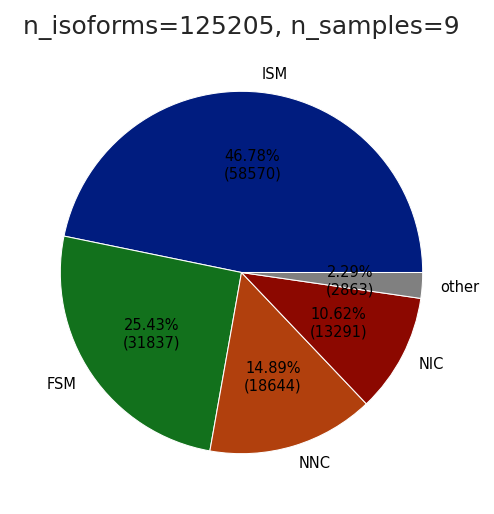

In [71]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct
vc=simplified_isoform_level_table_unfiltered["SupportingStructCategory"].map(lambda x: {
    "full-splice_match":"FSM",
    "incomplete-splice_match":"ISM",
    "novel_in_catalog":"NIC",
    "novel_not_in_catalog":"NNC"
}.get(x,"other")).value_counts()
colors = [
    sns.color_palette('dark')[0],
    sns.color_palette('dark')[2],
    sns.color_palette('dark')[1],
    sns.color_palette('dark')[3]
]+["grey"]
fig,ax=plt.subplots()
ax.pie(
    vc.values,labels=vc.index,colors=colors, 
    autopct=make_autopct(vc.values),
    textprops = {"fontsize":7,"color":"black"},
    wedgeprops = {"linewidth":0.5}
)
ax.set_title(f"n_isoforms={vc.sum()}, n_samples=9")
fig.set_size_inches((4,4))
fig.savefig("plots/QC/struct_pie_chart.pdf",bbox_inches="tight")

In [162]:
%%space common_isoforms_by_sc
sc_map={
    "full-splice_match":"FSM",
    "incomplete-splice_match":"ISM",
    "novel_in_catalog":"NIC",
    "novel_not_in_catalog":"NNC"
}
isoform_sets={
    "FSM":{"normal samples":set(),"tumor samples":set()},
    "ISM":{"normal samples":set(),"tumor samples":set()},
    "NIC":{"normal samples":set(),"tumor samples":set()},
    "NNC":{"normal samples":set(),"tumor samples":set()},
    "other":{"normal samples":set(),"tumor samples":set()},
}
normal_samples={"PS018-N","PS021-N","PS026-N2"}
tumor_samples={"PS017-T1.1","PS017-T2","PS018-T","PS025-T","PS026-T","PS028-T"}
for iso_id, qtiso in giv2.gffcmp_merged_transcripts.shared_iso_by_id.items():
    supporting_samples = set(qid.split("__")[1] for qid in qtiso.associated_data.get("supporting_query_isoform_id"))
    sc=sc_map.get(qtiso.associated_data.get("cls_record")["structural_category"],"other")
    if supporting_samples& normal_samples:
        if sc in isoform_sets:
            isoform_sets[sc]["normal samples"].add(iso_id)
    if supporting_samples& tumor_samples:
        if sc in isoform_sets:
            isoform_sets[sc]["tumor samples"].add(iso_id)

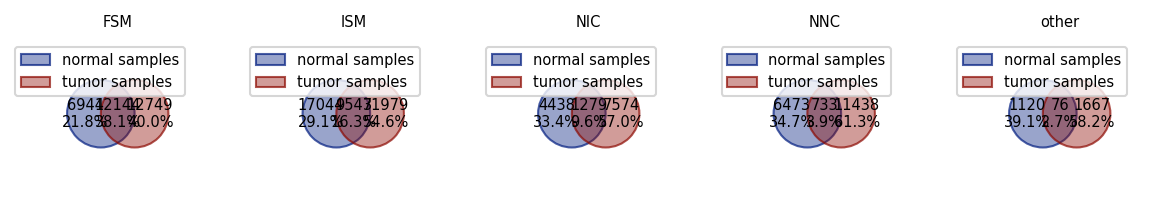

In [163]:
%%space common_isoforms_by_sc
from venn import venn
fig,axes=plt.subplots(1,5,figsize=(8,4))
fig.tight_layout()
axes=axes.flatten()
for i, (sc, collections) in enumerate(isoform_sets.items()):
    ax=axes[i]
    _=venn(collections,cmap=[sns.color_palette("dark")[0],sns.color_palette("dark")[3]],ax=ax,fontsize=7,fmt="{size}\n{percentage:.1f}%")
    _=ax.set_title(sc,fontsize=7)
if False:
    fig.savefig("plots/QC/isoform_normal_tumor_sample.pdf",bbox_inches="tight")

In [153]:
%%space common_barcodes_by_sample

sample_name_map={
    2: 'PS017-T',
    4: 'PS017-T',
    5: 'PS018-N',
    6: 'PS018-T',
    8: 'PS021-N',
    10: 'PS025-T',
    11: 'PS026-N',
    12: 'PS026-T',
    15: 'PS028-T'
}

IL_barcodes_by_sample=defaultdict(set)
PB_barcodes_by_sample=defaultdict(set)

for cb_sidx in giv2.cell_barcodes_pass_UMI_count_filter:
    cb,sidx=cb_sidx.split('-')
    sidx=int(sidx)
    sample_name=sample_name_map[sidx]
    PB_barcodes_by_sample[sample_name].add(cb_sidx)

for cb_sidx in giv2.illumina_sample_info.anndata.obs.index:
    cb,sidx=cb_sidx.split('-')
    sidx=int(sidx)
    if sidx in sample_name_map:
        sample_name=sample_name_map[sidx]
        IL_barcodes_by_sample[sample_name].add(cb_sidx)


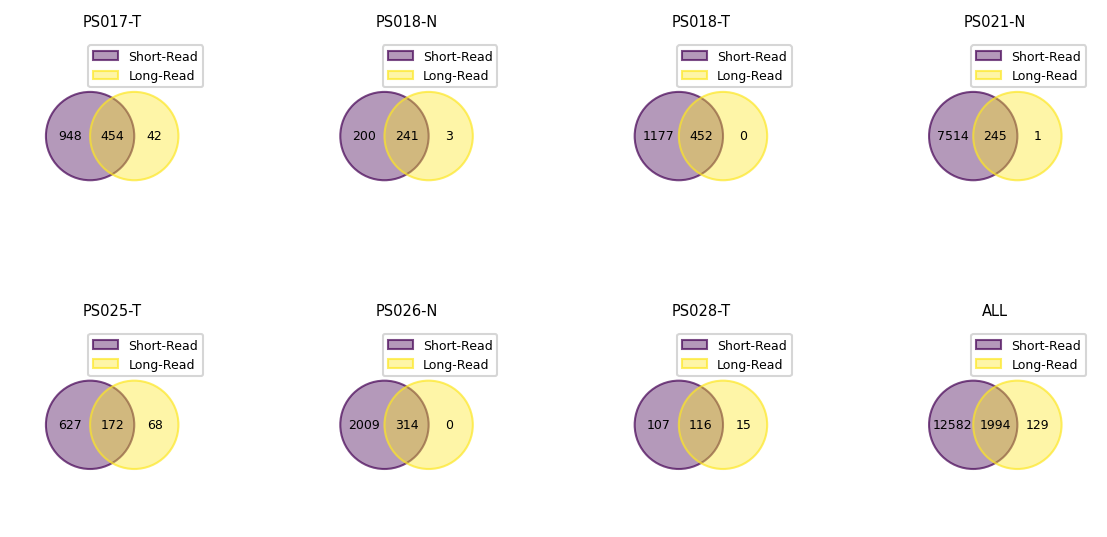

In [161]:
%%space common_barcodes_by_sample
from venn import venn
from itertools import chain
fig,axes=plt.subplots(2,4,figsize=(8,4))
fig.tight_layout()
axes=axes.flatten()
samples_to_plot=["PS017-T","PS018-N","PS018-T","PS021-N","PS025-T","PS026-N","PS028-T"]
for i,sample_name in enumerate(samples_to_plot):
    ax=axes[i]
    _=ax.set_title(sample_name,fontsize=7)
    _=venn(
        {
            "Short-Read":IL_barcodes_by_sample[sample_name],
            "Long-Read":PB_barcodes_by_sample[sample_name]
        },
        fontsize=6,
        ax=ax
    )
    
IL_barcodes_all=set(chain.from_iterable(IL_barcodes_by_sample[sn] for sn in samples_to_plot))
PB_barcodes_all=set(chain.from_iterable(PB_barcodes_by_sample[sn] for sn in samples_to_plot))


ax=axes[-1]
_=ax.set_title("ALL",fontsize=7)
_=venn(
    {
        "Short-Read":IL_barcodes_all,
        "Long-Read":PB_barcodes_all
    },
    fontsize=6,
    ax=ax
)

if True:
    fig.savefig("plots/QC/barcodes_per_sample.pdf",bbox_inches="tight")

## Simplified Gene Level Table

In [18]:
def gene_level_count_matrix(self,simplified_isoform_level_table,isoform_counts_ad):
    obs_names=list(self.cell_barcodes_all)
    obs_names2index=dict(zip(obs_names,range(len(obs_names))))
    var_names=sorted(simplified_isoform_level_table["GeneSymbol"].unique())
    var_names2index=dict(zip(var_names,range(len(var_names))))
    raw_count_matrix_data=list()
    raw_count_matrix_row=list()
    raw_count_matrix_col=list()
    groupby=simplified_isoform_level_table.groupby("GeneSymbol")
    for gene,group in tqdm(groupby):
        support_info=SupportInfo()
        for iso_id in group["Isoform"]:
            support_info.add_isoform_support(
                self.gffcmp_merged_transcripts.shared_iso_by_id[iso_id]\
                .associated_data.get("differential_analysis")["support_info"]
            )
        CB_UMI_counts=support_info.get_supporting_CB_UMI_counts()
        CB_UMI_counts={k:v for k,v in CB_UMI_counts.items() if k in obs_names2index}

        for cb, umi_count in CB_UMI_counts.items():
            value=umi_count
            row_idx=obs_names2index[cb]
            col_idx=var_names2index[gene]
            raw_count_matrix_data.append(value)
            raw_count_matrix_row.append(row_idx)
            raw_count_matrix_col.append(col_idx)
    counts_matrix_csr=sp.csr_matrix(
        (raw_count_matrix_data,(raw_count_matrix_row,raw_count_matrix_col)),
        shape=(len(obs_names2index),len(var_names2index))
    )
    
    counts_matrix_ad=ad.AnnData(counts_matrix_csr,dtype=np.int64)
    counts_matrix_ad.obs_names=obs_names
    counts_matrix_ad.var_names=var_names
    
    denominator=np.repeat(np.asarray(isoform_counts_ad.X.sum(axis=1))[:,0], counts_matrix_csr.getnnz(axis=1)).astype("float64")
    counts_matrix_csr_float=counts_matrix_csr.astype("float64")
    counts_matrix_csr_float.data/=(denominator+np.finfo("float64").eps)
    
    counts_matrix_csr_normalized=(counts_matrix_csr_float*1e4).log1p()
    data_matrix_csr=counts_matrix_csr_normalized
    data_matrix_ad=ad.AnnData(data_matrix_csr,dtype=np.float64)
    data_matrix_ad.obs_names=obs_names
    data_matrix_ad.var_names=var_names
    return counts_matrix_ad, data_matrix_ad

def make_simplified_gene_level_table(self,simplified_isoform_level_table,isoform_counts_ad):
    def cluster_midway_map_cell_type(cb):
        if cb in self.cell_barcodes_illumina_intersect:
            cell_type=self.illumina_sample_info.illumina_barcodes_cluster_midway_sn_map_pacbio_intersect[cb][1]
        elif cb in self.cell_barcodes_pass_UMI_count_filter:
            cell_type="_PB_CB_not_found_in_IL"
        else:
            cell_type="_PB_CB_filtered"
        return cell_type
    
    def cluster_full_map_cell_type(cb):
        if cb in self.cell_barcodes_illumina_intersect:
            cell_type=self.illumina_sample_info.illumina_barcodes_cluster_full_sn_map_pacbio_intersect[cb][1]
        elif cb in self.cell_barcodes_pass_UMI_count_filter:
            cell_type="_PB_CB_not_found_in_IL"
        else:
            cell_type="_PB_CB_filtered"
        return cell_type
    
    def sample_condition_map_cell_type(cb):
        if cb in self.sample_condition_sets["sample_normal"]:
            condition="sample_normal"
        elif cb in self.sample_condition_sets["sample_tumor"]:
            condition="sample_tumor"
        
        return condition
    
    cluster_midway_sorted_cell_types_IL=sorted(self.illumina_sample_info.cluster_midway_stats_pacbio_intersect)
    cluster_midway_sorted_cell_types=cluster_midway_sorted_cell_types_IL+["_PB_CB_not_found_in_IL","_PB_CB_filtered"]
    
    cluster_full_sorted_cell_types=sorted(set(self.illumina_sample_info.cluster_full_stats_pacbio_intersect)-set(["UNK"]))
    sample_condition_sorted_cell_types=["sample_normal","sample_tumor"]
    
    counts_matrix_ad, data_matrix_ad=gene_level_count_matrix(self,simplified_isoform_level_table,isoform_counts_ad)
    obs_names2index=zip(data_matrix_ad.obs.index,range(data_matrix_ad.shape[0]))
    var_names2index=zip(data_matrix_ad.var.index,range(data_matrix_ad.shape[1]))
    cluster_midway_raw_count_stats_all=cell_identity_stats(
        self,
        counts_matrix_ad,
        lambda x: cluster_midway_map_cell_type(x),
        log1p=False
    )
    
    cluster_midway_data_stats_all=cell_identity_stats(
        self,
        data_matrix_ad,
        lambda x: cluster_midway_map_cell_type(x),
        log1p=True
    )
    
    cluster_full_raw_count_stats_all=cell_identity_stats(
        self,
        counts_matrix_ad,
        lambda x: cluster_full_map_cell_type(x),
        log1p=False,
        exclusion=["UNK"]
    )
    
    cluster_full_data_stats_all=cell_identity_stats(
        self,
        data_matrix_ad,
        lambda x: cluster_full_map_cell_type(x),
        log1p=True,
        exclusion=["UNK"]
    )
    
    sample_condition_raw_count_stats_all=cell_identity_stats(
        self,
        counts_matrix_ad,
        lambda x: sample_condition_map_cell_type(x),
        log1p=False
    )
    
    sample_condition_data_stats_all=cell_identity_stats(
        self,
        data_matrix_ad,
        lambda x: sample_condition_map_cell_type(x),
        log1p=True
    )
    
    diff_analysis_barcodes=get_differential_analysis_barcodes(self)
    diff_analysis_results=dict()
    for da_key in diff_analysis_barcodes:
        group1,group2=diff_analysis_barcodes[da_key]
        print("differential_analysis of {}".format(da_key))
        diff_analysis_results[da_key]={
            'results_Fisher':fisher_exact_test(self,data_matrix_ad,log1p=True,group1=group1,group2=group2),
            'results_MWU':MWU_rank_sum_test(self,data_matrix_ad,log1p=True,group1=group1,group2=group2)
        }

    table_dict=defaultdict(list)
    for col_idx, gene in tqdm(enumerate(data_matrix_ad.var.index)):
        cluster_midway_raw_count_stats=cluster_midway_raw_count_stats_all[gene]
        cluster_midway_data_stats=cluster_midway_data_stats_all[gene]
        cluster_full_raw_count_stats=cluster_full_raw_count_stats_all[gene]
        cluster_full_data_stats=cluster_full_data_stats_all[gene]
        sample_condition_raw_count_stats=sample_condition_raw_count_stats_all[gene]
        sample_condition_data_stats=sample_condition_data_stats_all[gene]
        
        results_dict=dict(GeneSymbol=gene)
        for da_key in diff_analysis_results:
            results_dict["OddsRatio(%s)"%(da_key)]=diff_analysis_results[da_key]["results_Fisher"]["oddsr"][col_idx]
            results_dict["PV_Fisher(%s)"%(da_key)]=diff_analysis_results[da_key]["results_Fisher"]["pvalue"][col_idx]
            results_dict["AVGLogFC(%s)"%(da_key)]=diff_analysis_results[da_key]["results_MWU"]["logfc"][col_idx]
            results_dict["PV_MWU(%s)"%(da_key)]=diff_analysis_results[da_key]["results_MWU"]["pvalue"][col_idx]
        
        
        results_dict["NSupportingPB_CB"]=sum(
            v[0]
            for k,v in cluster_midway_raw_count_stats.items()
            if k!="_PB_CB_filtered"
        )
        results_dict["NSupportingIL_CB"]=sum(
            v[0]
            for k,v in cluster_midway_raw_count_stats.items()
            if k not in ["_PB_CB_filtered","_PB_CB_not_found_in_IL"]
        )
        
        for k in sample_condition_sorted_cell_types:
            if k in sample_condition_raw_count_stats:
                results_dict[k+"_CB"]=sample_condition_raw_count_stats[k][0]
                results_dict[k+"_CB_Total"]=len(self.sample_condition_sets[k])
            else:
                result_dict[k+"_CB"]=0
                result_dict[k+"_CB_Total"]=len(self.sample_condition_sets[k])
                
        for k in cluster_midway_sorted_cell_types:
            if k in cluster_midway_raw_count_stats:
                results_dict[k+"_CB"]=cluster_midway_raw_count_stats[k][0]
                results_dict[k+"_CB_Total"]=len(self.cluster_midway_sets[k])
            else:
                results_dict[k+"_CB"]=0
                results_dict[k+"_CB_Total"]=len(self.cluster_midway_sets[k])

        for k in cluster_full_sorted_cell_types:
            if k in cluster_full_raw_count_stats:
                results_dict[k+"_CB"]=cluster_full_raw_count_stats[k][0]
                results_dict[k+"_CB_Total"]=self.illumina_sample_info.cluster_full_stats_pacbio_intersect[k]
        
        results_dict["NSupportingPB_UMI_counts"]=sum(
            v[1] 
            for k,v in cluster_midway_raw_count_stats.items()
            if k!="_PB_CB_filtered"
        )
        results_dict["NSupportingCommonCB_UMI_counts"]=sum(
            v[1]
            for k,v in cluster_midway_raw_count_stats.items()
            if k not in ["_PB_CB_filtered","_PB_CB_not_found_in_IL"]
        )
        
        for k in sample_condition_sorted_cell_types:
            if k in sample_condition_raw_count_stats:
                results_dict[k+"_UMI_counts"]=sample_condition_raw_count_stats[k][1]
                
        for k in cluster_midway_sorted_cell_types:
            if k in cluster_midway_raw_count_stats:
                results_dict[k+"_UMI_counts"]=cluster_midway_raw_count_stats[k][1]


        for k in cluster_full_sorted_cell_types:
            if k in cluster_full_raw_count_stats:
                results_dict[k+"_UMI_counts"]=cluster_full_raw_count_stats[k][1]

        for k in sample_condition_sorted_cell_types:
            if k in sample_condition_data_stats:
                results_dict[k+"_UMI_data"]=sample_condition_data_stats[k][1]
                
        for k in cluster_midway_sorted_cell_types:
            if k in cluster_midway_data_stats:
                results_dict[k+"_UMI_data"]=cluster_midway_data_stats[k][1]


        for k in cluster_full_sorted_cell_types:
            if k in cluster_full_data_stats:
                results_dict[k+"_UMI_data"]=cluster_full_data_stats[k][1]
                    
        for k,v in results_dict.items():
            table_dict[k].append(v)
    return counts_matrix_ad, data_matrix_ad,pd.DataFrame(table_dict)

gene_counts_matrix_ad, gene_data_matrix_ad, simplified_gene_level_table=\
make_simplified_gene_level_table(giv2,simplified_isoform_level_table_unfiltered,isoform_counts_ad)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:02<00:00, 8608.34it/s]


Computing cell identity stats
Computing cell identity stats
Computing cell identity stats
Computing cell identity stats
Computing cell identity stats
Computing cell identity stats
differential_analysis of Epi stem vs rest
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:44<00:00, 451.26it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of Epi goblet_lineage vs Epi stem
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:35<00:00, 561.74it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of Epi enterocyte_lineage vs Epi stem
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:37<00:00, 534.66it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of Epi best4_lineage vs Epi stem
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:35<00:00, 557.25it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of EpiT stem 01 vs rest
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:56<00:00, 355.88it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of EpiT stem 02 vs rest
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:59<00:00, 335.03it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of EpiT stem 03 vs rest
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:59<00:00, 336.02it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of EpiT stem 01 vs Epi stem 01
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:34<00:00, 581.29it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of EpiT stem 02 vs Epi stem 02
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:39<00:00, 505.52it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...
differential_analysis of EpiT stem 03 vs Epi stem 03
Performing Fisher exact test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20023/20023 [00:46<00:00, 434.51it/s]


Performing MWU Test...
Computing Percentage...
Computing LogFC...


20023it [00:01, 12521.21it/s]
